In [21]:
import numpy as np
import matplotlib.pyplot as plt # Changed mathplotlib to matplotlib

import tensorflow as tf

# Correct the import statement
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Import pad_sequences
from tensorflow.keras.utils import pad_sequences # or from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report,roc_curve,auc

!pip install keras-tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch

In [8]:
# veri seti yükle, imdb 50000, (0=> olumsuz) (1=> olumlu)
imdb.load_data(num_words=10000) # num_words = en cok kullanılan 10000 kelimeyi al
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

In [9]:
#veri ön işleme: yorumları aynı uzunluğa getirmek için padding yöntemi kullanılyor
maxlen = 100
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [10]:
#create and compile RNN model

def build_model(hp): # hp = hyperparameter
  model = Sequential() #base mdoel

  # embedding katmanı: kelimeleri vektorlere cevirir
  model.add(Embedding(input_dim=10000,
                      output_dim=hp.Int("embedding_output",min_value=32,max_value=128,step=32),#vektör boyutlaru(32,64,96,128) olabilir
                      input_length=maxlen))

  # simpleRNN: rnn katmanı
  model.add(SimpleRNN(units=hp.Int("units",min_value=32,max_value=128,step=32))) # nöron sayısı(32,64,96,128) olabilir

  # dropout katmanı: overfittingi engellemek için rastgele bazı cell'leri kapatır
  model.add(Dropout(rate=hp.Float("dropout_rate",min_value=0.2,max_value=0.5,step=0.1)))

  # çıktı katmanı: 1 cell ve sigmoid
  model.add(Dense(1,activation="sigmoid")) # sigmoid activation: ikili sınıflandırma için kullanılır ( cıktı 1 ve 0 arasında olur)

  # modelin compile edilmesi
  model.compile(optimizer = hp.Choice("optimizer",["adam","rmsprop"]),# adam veya rmsprop kullanabilir
                loss="binary_crossentropy",# ikili sınıflandırma için kullanılan loss functionu
                metrics = ["accuracy","AUC"]# AUC: area under curve
                )
  return model

In [12]:
# hyperparameter search: random search ile hiperparametre aranacak
tuner = RandomSearch(
    build_model, # optimize edilecek model fonksiyonu
    objective="val_loss", # val_loss: en düşük olan en iyisidir, val_accuracy: yüksek olan en iyisidir.
    max_trials=2, # 2 farklı model deneyecek
    executions_per_trial=1 ,# her model için 1 eğitim denemesi
    directory = "rnn_tuner_directory", # modellerin kayıt edileceği dizin
    project_name = "imdb_rnn" # modellerin kayıt edileceği klasör (proje adı)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# erken doğrulama: doğrula hatası düzelmezse (azalmazsa) eğitimi durdur
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True)

In [14]:
# model eğitimi
history = tuner.search(
    x_train,
    y_train,
    epochs=5,
    validation_split=0.2, # eğitim veri setinin %20 sini validation alıyor
    callbacks=[early_stopping]
)

Trial 2 Complete [00h 02m 58s]
val_loss: 0.48407870531082153

Best val_loss So Far: 0.3885672390460968
Total elapsed time: 00h 05m 57s


In [15]:
#en iyi model alınması
best_model = tuner.get_best_models(num_models=1)[0] # en iyi performans gösteren model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# en iyi modeli kullanarak test et
loss,accuracy,auc_score = best_model.evaluate(x_test,y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC_Score: {auc_score:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - AUC: 0.9037 - accuracy: 0.8295 - loss: 0.3961
Test Loss: 0.3888
Test Accuracy: 0.8332
Test AUC_Score: 0.9071


In [19]:
# tahmin yapma ve modelin performansını değerlendirme
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32") # tahmin edilen değerler 0.5 den büyükse 1'e yuvarlanır yani olumlu olur

print(classification_report(y_test,y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [22]:
# roc eğrisi hesaplama
fpr,tpr,_ = roc_curve(y_test,y_pred_prob) #roc eğrisi için fpr(false positive rate) ve tpr(true positive rate)
roc_auc = auc(fpr,tpr) # roc eğrisinin altında kalan alan hesaplanır

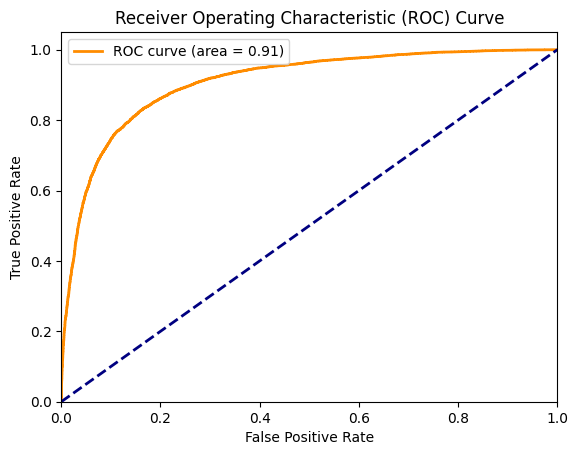

In [23]:
# roc eğrisi görselleştirme
plt.figure()
plt.plot(fpr,tpr,color="darkorange",lw=2,label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0,1],[0,1],color="navy",lw=2,linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()